In [1]:
import rasterio
import rasterio.mask
from rasterio import plot

import matplotlib.pyplot as plt
%matplotlib inline

import os
from osgeo import gdal

import numpy as np

import geopandas as gpd

In [2]:
os.getcwd()

'C:\\Users\\PC\\PLUS_softwaredev_2022\\A3'

In [3]:
# define in and output path
path_in = '..\\..\\Desktop\\Austria\\SoftwareDev_Python\\A3\\S2B_MSIL1C_20220106T102319_N0301_R065_T33UUU_20220106T111539\\S2B_MSIL1C_20220106T102319_N0301_R065_T33UUU_20220106T111539.SAFE\\GRANULE\\L1C_T33UUU_A025259_20220106T102345\\IMG_DATA\\'
path_out = '..\\..\\Desktop\\Austria\\SoftwareDev_Python\\A3\\\\Output\\'

In [4]:
# Create strings with names of bands
blue='T33UUU_20220106T102319_B02'
green='T33UUU_20220106T102319_B03'
red='T33UUU_20220106T102319_B04'
red1= 'T33UUU_20220106T102319_B05'
red2= 'T33UUU_20220106T102319_B06'
red3= 'T33UUU_20220106T102319_B07'
nir= 'T33UUU_20220106T102319_B08'
red4= 'T33UUU_20220106T102319_B8A'
swir1= 'T33UUU_20220106T102319_B11'
swir2= 'T33UUU_20220106T102319_B12'

In [ ]:
# Convert all bands from .jp2 into .tif
bandList = [band for band in os.listdir(path_in) if band[-4:]=='.jp2']

for band in bandList:
    in_image = gdal.Open(path_in + band)
    driver = gdal.GetDriverByName("GTiff")
    fp_tiff = path_out + band[:-4] + '.tif'
    out_image = driver.CreateCopy(fp_tiff, in_image, 0)
    in_image = None
    out_image = None

In [5]:
# define filePath for each converted S2 image and open them
b2= rasterio.open(path_out + blue + '.tif')
b3 = rasterio.open(path_out + green + '.tif')
b4 = rasterio.open(path_out + red + '.tif')
b8 = rasterio.open(path_out + nir + '.tif')

In [6]:
# read the opened files
b2_blue = b2.read(1)
b3_green = b3.read(1)
b4_red = b4.read(1)
b8_nir = b8.read(1)

In [7]:
# Create RGB stack
with rasterio.open(path_out + 'RGB.tiff','w',driver='Gtiff', width=b2.width, height=b2.height, 
              count=3,crs=b2.crs,transform=b2.transform, dtype=b2.dtypes[0]) as rgb:
    rgb.write(b2_blue,1) 
    rgb.write(b3_green,2) 
    rgb.write(b4_red,3) 
    rgb.close()

In [9]:
# Crop image to smaller extent
shp = gpd.read_file("..\\..\\Desktop\\Austria\\SoftwareDev_Python\\A3\\clip.shp")

# reproject area of interest to S2 projection
shp_proj = shp.to_crs({'init': 'epsg:32633'})


C:\Users\PC\miniconda3\envs\my_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [10]:
# open RGB image, get metadata and masked image to area of interest and save
with rasterio.open(path_out + "RGB.tiff") as src:
    out_image, out_transform = rasterio.mask.mask(src, shp_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rasterio.open(path_out + "RGB_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [11]:
# read Red(b4) and NIR(b8) as arrays
red = b4.read()
nir = b8.read()

# Calculate ndvi
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)

# Write the NDVI image
meta = b4.meta
meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

with rasterio.open(path_out + 'NDVI.tif', 'w', **meta) as dst:
    dst.write(ndvi.astype(rasterio.float32))

In [12]:
ndvi.shape

(1, 10980, 10980)

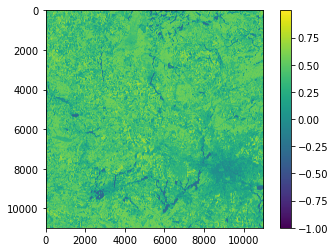

In [13]:
# Remove byte column 
image = ndvi[0]     

# plot raw pixel data
plt.imshow(np.squeeze(image))   
plt.colorbar()